# Phase 1: Die Daten verstehen (Explorative Datenanalyse)

Im Projekt **„Degrees of No Return“** wollen wir globale Klimadaten so übersetzen, dass sie lokale Risiken greifbar machen. Diese erste Phase, die explorative Datenanalyse (EDA), ist dafür das Fundament. Hier prüfen wir die Qualität, die Struktur und die Eigenheiten unserer Rohdaten, um sicherzustellen, dass die Vorhersagen unserer späteren Web-App auf einer soliden wissenschaftlichen Grundlage stehen.

## Aufgabe 1: Wahl und Beschreibung der Datensätze

Um die zentralen Forschungsfragen unseres Projekts zu beantworten – die Verknüpfung von CO₂-Anstieg mit lokaler Hitze und Meeresspiegelanstieg mit lokaler Überflutungsgefahr – nutzen wir vier anerkannte, wissenschaftliche Datenquellen. Im Folgenden werden diese detailliert beschrieben.

### 1. Globale Temperaturveränderungen (NASA GISS Surface Temp v4)
*   **Herkunft:** NASA Goddard Institute for Space Studies (GISS).
*   **Erhebungsmethode:** Der Datensatz kombiniert Messungen von Tausenden Wetterstationen an Land mit ozeanografischen Oberflächendaten. Diese werden auf ein globales Raster umgerechnet, um eine konsistente, weltweite Abdeckung zu gewährleisten.
*   **Erfassungszeitraum:** 1880 bis heute (monatliche Daten).
*   **Datenstruktur:** Gespeichert im NetCDF-Format (`.nc`), einem Standard für wissenschaftliche, mehrdimensionale Daten. Er enthält über 1.700 Zeitschritte (Monate) auf einem globalen 90x180-Grad-Raster, was die räumliche und zeitliche Dimension abbildet.
*   **Verwendungszweck im Projekt:** Dies ist unsere **„Ground Truth“ für Temperatur**. Das Machine-Learning-Modell unserer App lernt aus diesen historischen Daten den Zusammenhang zwischen globalen Treibern (wie CO₂) und der tatsächlichen Erwärmung. Dies ist die Basis, um für die Zukunft die Zunahme von **lokalen Hitzetagen** zu prognostizieren.

### 2. CO₂-Konzentration in der Atmosphäre (NOAA Mauna Loa)
*   **Herkunft:** NOAA Global Monitoring Laboratory (GML), bekannt als die „Keeling-Kurve“.
*   **Erhebungsmethode:** Direktmessung (in-situ) der atmosphärischen CO₂-Konzentration auf dem Mauna Loa Observatorium auf Hawaii, die als Referenz für die globale CO₂-Entwicklung gilt.
*   **Erfassungszeitraum:** 1958 bis heute (monatliche Daten).
*   **Datenstruktur:** Einfaches CSV-Format, das neben dem Datum vor allem den `average` (gemittelter Messwert) und den `deseasonalized` (saisonbereinigter) Wert enthält.
*   **Verwendungszweck im Projekt:** Der CO₂-Wert ist der **zentrale globale Treiber (Prädiktor)** für die Klimaerwärmung. Unsere App wird ein Modell nutzen, das lernt, wie Veränderungen in dieser Datenreihe die lokalen Temperaturen beeinflussen. Damit können Nutzer im Frontend verschiedene Emissionsszenarien durchspielen.

### 3. Globaler Meeresspiegelanstieg (EPA / CSIRO / NOAA)
*   **Herkunft:** Kombinierte Daten von führenden Klimabehörden wie EPA, CSIRO und NOAA.
*   **Erhebungsmethode:** Der Datensatz fusioniert zwei Datenquellen: historische Messungen von Küstenpegeln (Tide Gauges) und hochpräzise, moderne Satelliten-Altimetriedaten seit 1993.
*   **Erfassungszeitraum:** 1880 bis heute (jährliche Daten).
*   **Datenstruktur:** CSV-Format mit dem `CSIRO Adjusted Sea Level` als Hauptmerkmal sowie Fehlergrenzen (`Lower/Upper Error Bound`), die die Unsicherheit der Messungen angeben.
*   **Verwendungszweck im Projekt:** Dieser Datensatz liefert die **historische Zielvariable** für das Überflutungsrisiko. Unser Modell lernt den Zusammenhang zwischen globaler Erwärmung und dem Anstieg des Meeresspiegels. In der App kann der Nutzer dann über einen Zeit-Slider sehen, wie sich die prognostizierte Meeresspiegeländerung auf die lokale Topografie auswirkt.

### 4. Detaillierte 3D-Karte der Erdoberfläche (Copernicus DEM)
*   **Herkunft:** Europäische Weltraumorganisation (ESA), bereitgestellt via Cloud-Dienst (AWS S3).
*   **Erhebungsmethode:** Globales digitales Höhenmodell (DEM), das mittels Satelliten-Radar-Messungen mit einer horizontalen Auflösung von ca. 30 Metern erstellt wurde.
*   **Erfassungszeitraum:** Es handelt sich um eine statische, aktuelle Abbildung der Topografie.
*   **Datenstruktur:** GeoTIFF, ein Standardformat für Geodaten. Jeder Pixel in der Datei repräsentiert einen exakten Höhenwert.
*   **Verwendungszweck im Projekt:** Dies ist die **räumliche Grundlage für die lokale Risikoanalyse**. Wenn unser Modell einen bestimmten Meeresspiegelanstieg vorhersagt, dient diese hochaufgelöste Karte dazu, die potenziellen Überflutungsflächen zu berechnen und in der interaktiven Karte der Web-App zu visualisieren. Erst dadurch wird die globale Gefahr für den Nutzer lokal sichtbar.

---


## Aufgabe 2: Ein Bild sagt mehr als tausend Zahlen – erste Grafiken

Diagramme und Karten sind der beste Weg, um Muster, Trends oder auch Fehler in den Daten schnell zu erkennen. Bevor wir mit der grafischen Analyse für das Projekt **„Degrees of No Return“** beginnen, laden wir die notwendigen Software-Werkzeuge (sogenannte Python-Bibliotheken), die uns dabei helfen, die komplexen Raum- und Zeitdaten zu visualisieren.

In [ ]:
# Importieren der benötigten Bibliotheken
from pathlib import Path
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.session import AWSSession
import numpy as np

### Vorbereitung: Daten laden
Jetzt teilen wir dem Programm mit, wo die Datendateien auf dem Computer gespeichert sind, und laden sie. Die 3D-Karte für unsere Beispielregion Düsseldorf rufen wir dabei direkt aus dem Internet ab.

In [ ]:
# Pfade definieren
base_dir = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd() / "data"
co2 = base_dir / "co2_mm_mlo.csv"
sea_level = base_dir / "epa_sea_level.csv"
tempanomaly = base_dir / "gistemp1200_GHCNv4_ERSSTv5.nc"

# Existenz aller Dateien überprüfen
files_to_check = [co2, sea_level, tempanomaly]
missing = [str(f) for f in files_to_check if not f.exists()]
if missing:
    raise FileNotFoundError(f"Folgende Dateien fehlen: {', '.join(missing)}")

# Daten einlesen
df_co2 = pd.read_csv(co2, comment="#", on_bad_lines="skip", engine="python")
df_sea_level = pd.read_csv(sea_level, comment="#", on_bad_lines="skip", engine="python")
dataset_tempanomaly = xr.open_dataset(tempanomaly)

# Die direkte S3-URL für die Kachel Düsseldorf/Rheinland
aws_url_topography = "s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N51_00_E006_00_DEM/Copernicus_DSM_COG_10_N51_00_E006_00_DEM.tif"


### 2.1 Der unaufhaltsame Anstieg: Die CO₂-Konzentration

Diese Grafik ist zentral für das Verständnis des Klimawandels. Sie zeigt die Entwicklung der CO₂-Konzentration in der Atmosphäre.

*   Die **grüne Linie** (monatliche Messung) zeigt ein klares "Zick-Zack"-Muster. Dies sind die natürlichen, saisonalen Schwankungen, die z.B. durch die Vegetation auf der Nordhalbkugel verursacht werden (Pflanzen nehmen im Sommer CO₂ auf und geben es im Winter wieder ab).
*   Die **rote Linie** (`deseasonalized`) ist für unser Projekt entscheidend. Sie glättet diese saisonalen Schwankungen und offenbart den eigentlichen, langfristigen Trend. Dieser unaufhaltsame Anstieg ist der Motor des Klimawandels, den wir in der „Degrees of No Return“-App modellieren wollen.

In [ ]:
# Zeitspalte erstellen und als Index setzen
df_co2['date'] = pd.to_datetime(df_co2[['year','month']].assign(day=1))
df_co2 = df_co2.set_index('date').sort_index()

# Liniendiagramm erstellen
plt.figure(figsize=(12,5))
plt.plot(df_co2.index, df_co2['average'], color='green', alpha=0.6, label='Monatliche Messung')
plt.plot(df_co2.index, df_co2['deseasonalized'], color='red', alpha=0.6, label='Deseisonalisierte Messung')
plt.title('CO₂-Konzentration über die Zeit')
plt.xlabel('Datum')
plt.ylabel('CO₂ (ppm)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### 2.2 Steigende Ozeane: Der globale Meeresspiegel

Diese Grafik zeigt, wie der globale Meeresspiegel seit 1880 angestiegen ist. Für unser Projekt ist die Transparenz über Datenunsicherheiten, insbesondere gegenüber unserer Zielgruppe aus Planung und Versicherungswesen, essenziell.

*   Die **blaue Linie** (`CSIRO Adjusted Sea Level`) stellt den wissenschaftlich angepassten Mittelwert dar.
*   Der **hellblau schattierte Bereich** ist der „Fehlerbereich“ (`Error Bound`). Er visualisiert die Unsicherheit, die vor allem in den älteren Messungen vor der Satelliten-Ära (vor 1993) vorhanden ist. Der wahre Wert lag historisch wahrscheinlich innerhalb dieser Spanne.
*   Die **rote Linie** zeigt den geglätteten 5-Jahres-Mittelwert und macht so den langfristigen Trend noch deutlicher sichtbar.

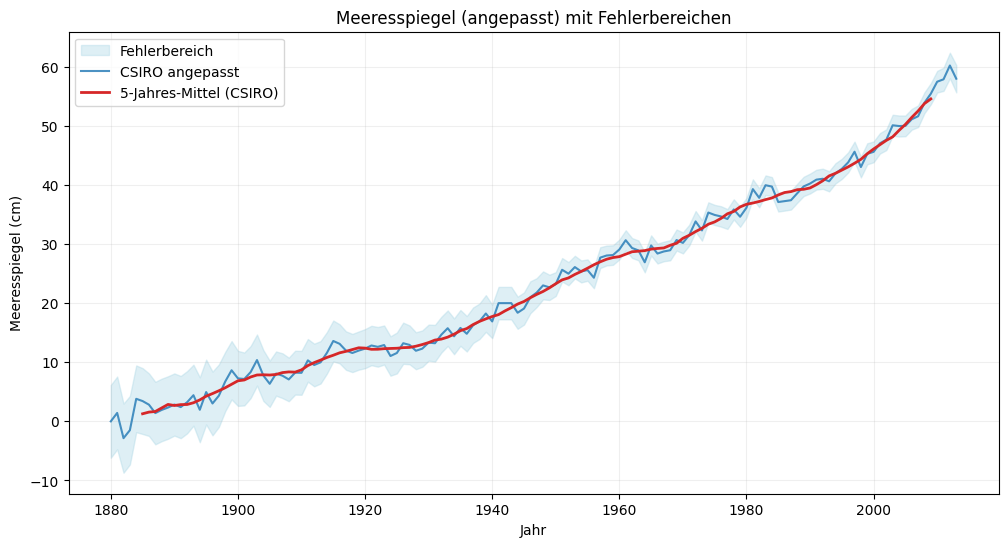

In [10]:
# Zeitspalte erstellen und als Index setzen
df_sea_level['date'] = pd.to_datetime(df_sea_level['Year'].astype(int).astype(str), format='%Y')
df_sea_level = df_sea_level.set_index('date').sort_index()

# Einheiten von Zoll (inch) in Meter umrechnen
inch_to_cm = 2.54
for col in ['Lower Error Bound', 'Upper Error Bound', 'CSIRO Adjusted Sea Level']:
    df_sea_level[col] = df_sea_level[col].astype(float) * inch_to_cm

# Liniendiagramm erstellen
plt.figure(figsize=(12,6))
plt.fill_between(df_sea_level.index, df_sea_level['Lower Error Bound'], df_sea_level['Upper Error Bound'], color='lightblue', alpha=0.4, label='Fehlerbereich')
plt.plot(df_sea_level.index, df_sea_level['CSIRO Adjusted Sea Level'], label='CSIRO angepasst', color='tab:blue', alpha=0.8)
plt.plot(df_sea_level['CSIRO Adjusted Sea Level'].rolling(10, center=True).mean(), color='tab:red', linewidth=2, label='5‑Jahres‑Mittel (CSIRO)')
plt.title('Meeresspiegel (angepasst) mit Fehlerbereichen')
plt.xlabel('Jahr')
plt.ylabel('Meeresspiegel (cm)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### 2.3 Eine Welt, unterschiedliche Erwärmung: Die globale Temperaturkarte

Die Web-App „Degrees of No Return“ soll globale Phänomene lokal erlebbar machen. Diese Weltkarte ist der erste Schritt dieses „Downscaling“-Prozesses. Sie zeigt die **Temperaturanomalien** im Januar 2024.

Eine **Anomalie** ist nicht die absolute Temperatur, sondern die Abweichung von einem langjährigen Durchschnitt (hier: 1951-1980). Rote Gebiete waren also deutlich wärmer als für einen Januar üblich, blaue Gebiete waren kühler. 

Man erkennt klar globale Muster: Regionen wie die Arktis oder Nordamerika erwärmen sich signifikant schneller als andere. Im nächsten Schritt wird unser Modell lernen, aus diesem globalen Muster eine präzise Vorhersage für eine konkrete, lokale Region abzuleiten.

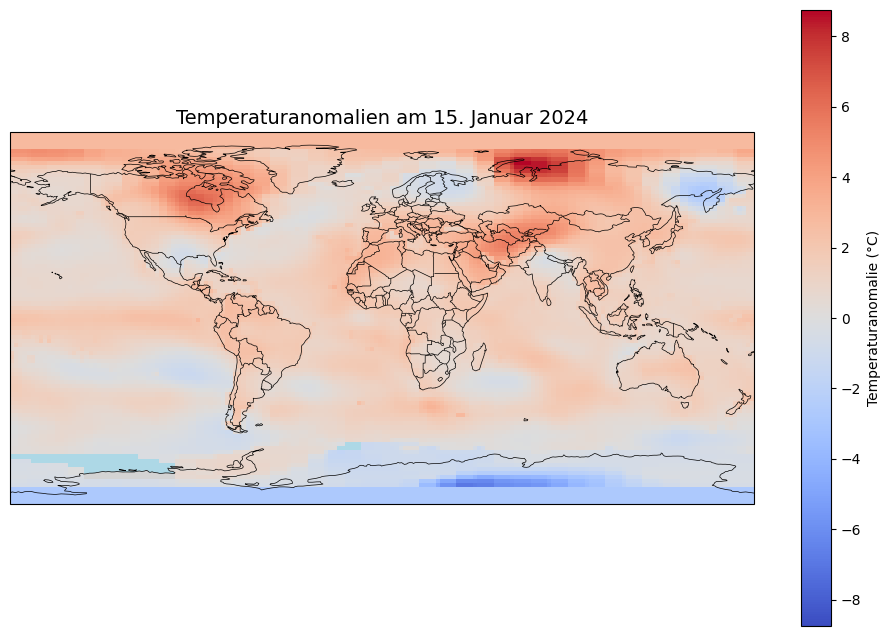

In [11]:
# Jahr für die Auswahl der Daten
year = 2024

# Temperaturanomalien für einen bestimmten Zeitpunkt auswählen
tempanomaly = dataset_tempanomaly["tempanomaly"].sel(time=f"{year}-01-15")

# Plot erstellen
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}  # Kartenprojektion
)

# Weltkarte hinzufügen
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Küstenlinien
ax.add_feature(cfeature.BORDERS, linewidth=0.5)    # Ländergrenzen
ax.add_feature(cfeature.LAND, facecolor="lightgray")  # Landflächen
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Ozeanflächen

# Temperaturanomalien plotten
tempanomaly.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Projektion der Daten
    cmap="coolwarm",               # Farbskala
    cbar_kwargs={"label": "Temperaturanomalie (°C)"},  # Farblegende
)

# Titel hinzufügen
ax.set_title(f"Temperaturanomalien am 15. Januar {year}", fontsize=14)

# Plot anzeigen
plt.show()

### 2.4 Lokales Risiko: Die 3D-Geländekarte von Düsseldorf

Hier sehen wir die „Leinwand“ für eine der Kernfunktionen unserer App: die Visualisierung von Überflutungsrisiken. Die Karte zeigt ein digitales Höhenmodell (DEM) für den Großraum Düsseldorf.

Jede Farbe repräsentiert eine bestimmte Höhe über dem Meeresspiegel. Dunkle, blau-grüne Bereiche liegen tief (z.B. der Rhein), gelbe und braune Farbtöne stellen höhere Lagen dar. Wenn unser Modell einen zukünftigen Meeresspiegelanstieg prognostiziert, werden wir auf Basis dieser exakten Höhendaten berechnen und visualisieren, welche Flächen überflutet würden. So wird aus einer abstrakten globalen Zahl eine konkrete, lokale Betroffenheit.

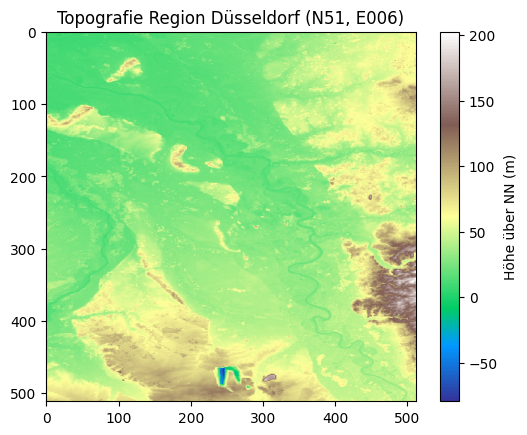

In [12]:
# Umgebung mit anonymem Zugriff starten, Daten verkleinert (512x512) laden und direkt plotten
with rasterio.Env(AWSSession(aws_unsigned=True)):
    with rasterio.open(aws_url_topography) as src:
        plt.imshow(src.read(1, out_shape=(512, 512)), cmap='terrain')
        plt.colorbar(label='Höhe über NN (m)')
        plt.title("Topografie Region Düsseldorf (N51, E006)")
        plt.show()

---

## Aufgabe 3: Die Detektivarbeit – Umgang mit fehlenden Daten

Ein zentrales Qualitätsversprechen unseres Projekts ist die wissenschaftliche Nachvollziehbarkeit. Daher ist es entscheidend, Datenlücken nicht nur zu finden, sondern zu verstehen, *warum* sie existieren.


In [13]:
# 1. Spezifische Bereinigung des CO2-Datensatzes
# Die NOAA markiert fehlende Metadaten in den frühen Jahren mit spezifischen Platzhaltern
df_co2['ndays'] = df_co2['ndays'].replace(-1, np.nan)
df_co2['sdev'] = df_co2['sdev'].replace(-9.99, np.nan)
df_co2['unc'] = df_co2['unc'].replace(-0.99, np.nan)

print("--- CO2 Datensatz: Fehlende Werte ---")
co2_missing = df_co2.isnull().sum()
co2_missing_pct = (co2_missing / len(df_co2)) * 100
print(pd.DataFrame({'Absolut': co2_missing, 'Prozentual (%)': co2_missing_pct.round(2)}))

print("\n--- Meeresspiegel Datensatz: Fehlende Werte ---")
sea_missing = df_sea_level.isnull().sum()
sea_missing_pct = (sea_missing / len(df_sea_level)) * 100
print(pd.DataFrame({'Absolut': sea_missing, 'Prozentual (%)': sea_missing_pct.round(2)}))

--- CO2 Datensatz: Fehlende Werte ---
                Absolut  Prozentual (%)
year                  0            0.00
month                 0            0.00
decimal date          0            0.00
average               0            0.00
deseasonalized        0            0.00
ndays               195           23.93
sdev                196           24.05
unc                 194           23.80

--- Meeresspiegel Datensatz: Fehlende Werte ---
                          Absolut  Prozentual (%)
Year                            0            0.00
CSIRO Adjusted Sea Level        0            0.00
Lower Error Bound               0            0.00
Upper Error Bound               0            0.00
NOAA Adjusted Sea Level       113           84.33


### Erkenntnisse und strategische Entscheidung

Die Analyse zeigt, dass die Datenlücken nicht zufällig sind, sondern strukturelle, also historisch und technisch bedingte, Ursachen haben:

1.  **CO₂-Daten:** Die Kern-Messwerte (`average`) sind vollständig. Es fehlen lediglich Metadaten wie die Standardabweichung (`sdev`) oder Messunsicherheit (`unc`) in den Jahren vor 1974. Der Grund: Das Bewusstsein für den Klimawandel und die damit einhergehende Notwendigkeit feingranularer statistischer Analysen war noch nicht so ausgeprägt, weshalb die Messprotokolle damals einfacher waren und diese Zusatzinformationen nicht erfasst wurden.
2.  **Meeresspiegel-Daten:** Die Spalte `NOAA Adjusted Sea Level` weist für die Zeit vor 1993 eine Lücke von ca. 84% auf. Der Grund ist technischer Natur: Diese Messreihe basiert rein auf Satellitendaten (Altimetrie), und diese Technologie steht erst seit 1993 zur Verfügung. Für die Jahre davor *kann* es logischerweise keine Satellitendaten geben.

**Strategie: Keine künstliche Daten-Imputation**

Wie in unserer Projekt-Charta (`AGENT.md`) festgelegt, muss unser Ansatz nachvollziehbar und wissenschaftlich fundiert sein. Eine künstliche „Erfindung“ von fehlenden Werten durch statistische Verfahren (Imputation) wäre hier grob fehlerhaft und würde die Glaubwürdigkeit der „Degrees of No Return“-App untergraben.

*   **Konsequenz für das Modell:** Wir werden ausschließlich die durchgängig verfügbaren und validen Kern-Features für das Training der Modelle verwenden. Dies sind der `deseasonalized`-Wert beim CO₂ und der `CSIRO Adjusted Sea Level` beim Meeresspiegel. Die unvollständigen Spalten werden für die Modellierung ignoriert.

## Aufgabe 4: Alles auf einen vergleichbaren Maßstab bringen (Skalierung)

Für das Projekt „Degrees of No Return“ kombinieren wir Daten mit völlig unterschiedlichen Wertebereichen: CO₂-Konzentration (Werte über 400), Meeresspiegel (Werte bis 25 cm) und Temperaturanomalien (Werte um ±2 °C). Ein Machine-Learning-Modell würde den rein numerisch größeren Werten (wie CO₂) fälschlicherweise mehr Bedeutung beimessen.

Um dies zu verhindern und einen fairen Vergleich der unterschiedlichen Trends zu ermöglichen, müssen wir alle Daten auf einen einheitlichen Maßstab bringen. Dieser Prozess wird Skalierung oder Normalisierung genannt.

### 4.1 Wahl der Skalierungsmethoden

Je nach Datentyp und geplantem Modelltyp wenden wir unterschiedliche, aber für den jeweiligen Zweck bewährte, Standardverfahren an:

1.  **Zeitreihen (CO₂ & Meeresspiegel):** Hier kommt der `StandardScaler` zum Einsatz. Er transformiert die Daten so, dass ihr Mittelwert bei 0 und ihre Standardabweichung bei 1 liegt. Dies ist ideal, um die relativen Stärken der Trends in statistischen Modellen oder neuronalen Netzen objektiv miteinander vergleichen zu können.
2.  **Topografische Geodaten (Copernicus DEM):** Das Höhenmodell wird im späteren Verlauf wie ein Bild von einem neuronalen Netz verarbeitet. Für solche bildbasierten Modelle (z.B. Convolutional Neural Networks) ist die `MinMaxScaler`-Methode der absolute Industriestandard. Sie skaliert alle Höhenwerte auf einen Bereich zwischen 0 (niedrigster Punkt) und 1 (höchster Punkt), was eine stabile und effiziente Verarbeitung im Modell sicherstellt.
3.  **Temperaturanomalien (GISTEMP):** Dies ist ein Sonderfall. Da Anomalien per Definition bereits Abweichungen von einem Mittelwert sind und um 0 schwanken, verzichten wir hier zunächst auf eine erneute Skalierung. So bleibt die direkte physikalische Bedeutung (z.B. das „+1,5-Grad-Ziel“) für die Visualisierungen in der Web-App erhalten.

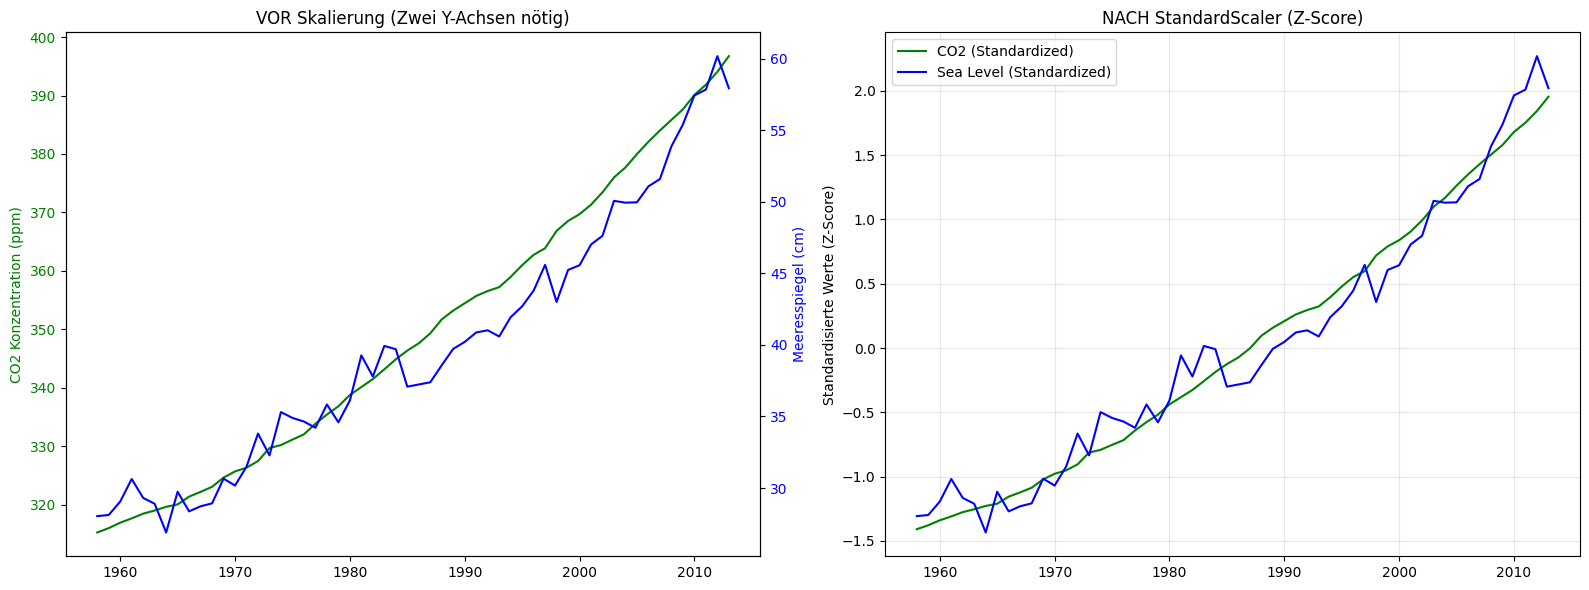

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# 1. Datenvorbereitung: CO2-Daten auf jährliche Durchschnittswerte aggregieren, um sie mit Sea Level zu mergen
df_co2_yearly = df_co2[['average']].resample('YE').mean()
df_co2_yearly.index = df_co2_yearly.index.year # Index auf reines Jahr setzen

df_sea_yearly = df_sea_level[['CSIRO Adjusted Sea Level']].copy()
df_sea_yearly.index = df_sea_yearly.index.year

# DataFrames zusammenführen (Inner Join über die Jahre, die in beiden existieren)
df_combined = pd.merge(df_co2_yearly, df_sea_yearly, left_index=True, right_index=True)
df_combined.columns = ['CO2 (ppm)', 'Sea Level (cm)']

# 2. Skalierung implementieren (StandardScaler)
scaler_ts = StandardScaler()
df_scaled = pd.DataFrame(
    scaler_ts.fit_transform(df_combined), 
    columns=df_combined.columns, 
    index=df_combined.index
)

# 3. Vorher-Nachher-Vergleich (Scatterplots und Linien)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# VORHER: Unterschiedliche Skalen verzerren das Bild optisch
ax1.plot(df_combined.index, df_combined['CO2 (ppm)'], label='CO2 (ppm)', color='green')
ax1.set_ylabel('CO2 Konzentration (ppm)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax1_twin = ax1.twinx()
ax1_twin.plot(df_combined.index, df_combined['Sea Level (cm)'], label='Sea Level (cm)', color='blue')
ax1_twin.set_ylabel('Meeresspiegel (cm)', color='blue')
ax1_twin.tick_params(axis='y', labelcolor='blue')
ax1.set_title('VOR Skalierung (Zwei Y-Achsen nötig)')

# NACHHER: Auf einer gemeinsamen Skala direkt vergleichbar
ax2.plot(df_scaled.index, df_scaled['CO2 (ppm)'], label='CO2 (Standardized)', color='green')
ax2.plot(df_scaled.index, df_scaled['Sea Level (cm)'], label='Sea Level (Standardized)', color='blue')
ax2.set_title('NACH StandardScaler (Z-Score)')
ax2.set_ylabel('Standardisierte Werte (Z-Score)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Wertebereich VORHER: Min = -79.59174346923828 m, Max = 202.7196807861328 m
Wertebereich NACHHER: Min = 0.0, Max = 1.0


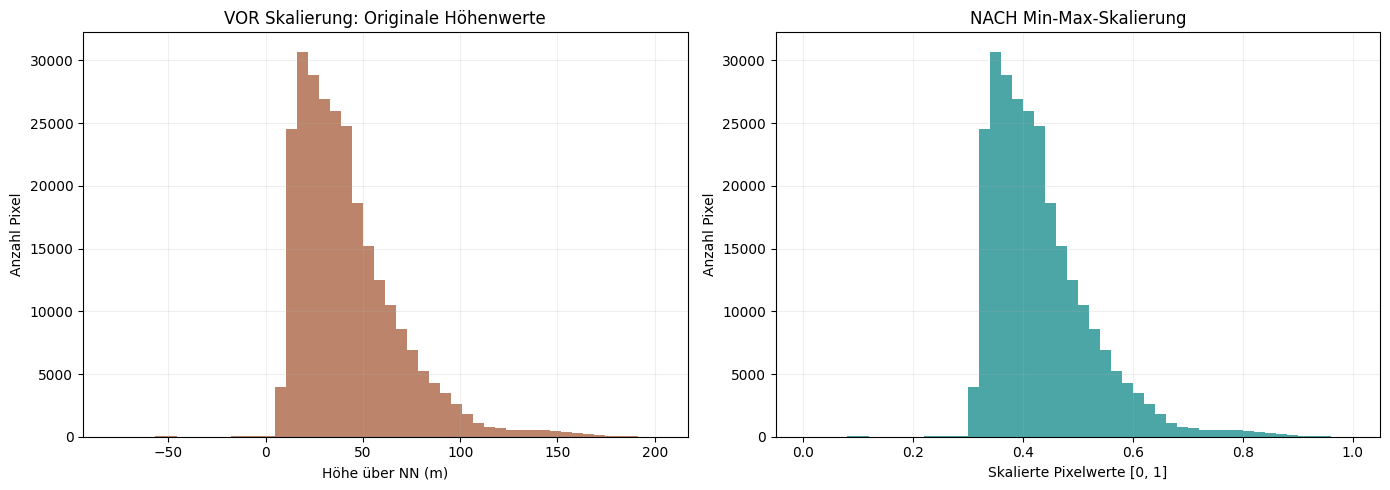

In [15]:
# 1. Höhenmodell (Copernicus DEM) laden (wie in Aufgabe 2)
with rasterio.Env(AWSSession(aws_unsigned=True)):
    with rasterio.open(aws_url_topography) as src:
        dem_data = src.read(1, out_shape=(512, 512))

# 2. Skalierung implementieren (MinMaxScaler für Bilddaten)
# MinMaxScaler erwartet ein 2D-Array in Form (Samples, Features), daher flatten und reshape
scaler_img = MinMaxScaler()
dem_scaled = scaler_img.fit_transform(dem_data.reshape(-1, 1)).reshape(dem_data.shape)

# 3. Vorher-Nachher-Vergleich (Histogramme der Pixelwerte)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# VORHER: Originale Höhenmeter
ax1.hist(dem_data.flatten(), bins=50, color='sienna', alpha=0.7)
ax1.set_title('VOR Skalierung: Originale Höhenwerte')
ax1.set_xlabel('Höhe über NN (m)')
ax1.set_ylabel('Anzahl Pixel')
ax1.grid(alpha=0.2)

# NACHHER: [0, 1] normiert
ax2.hist(dem_scaled.flatten(), bins=50, color='teal', alpha=0.7)
ax2.set_title('NACH Min-Max-Skalierung')
ax2.set_xlabel('Skalierte Pixelwerte [0, 1]')
ax2.set_ylabel('Anzahl Pixel')
ax2.grid(alpha=0.2)

# Wertebereiche vor und nach der Skalierung ausgeben
print(f"Wertebereich VORHER: Min = {dem_data.min()} m, Max = {dem_data.max()} m")
print(f"Wertebereich NACHHER: Min = {dem_scaled.min()}, Max = {dem_scaled.max()}")

plt.tight_layout()
plt.show()

### 4.2 Auswirkungen auf die Machine-Learning-Algorithmen

Die durchgeführten Skalierungen haben eine direkte, entscheidende Auswirkung auf das anstehende Modelltraining für die Web-App „Degrees of No Return“:

*   **Erhaltung der Informationsstruktur:** Wie die Grafiken zeigen, bleiben die relativen Verteilungen und Trends der Daten exakt erhalten. Wir ändern nur den Maßstab, nicht die Information selbst.
*   **Auswirkung auf das Zeitreihen-Modell (Temperatur/CO₂):** Durch den `StandardScaler` werden CO₂- und Meeresspiegeldaten auf einen gemeinsamen Wertebereich gebracht. Dies verhindert, dass das Modell dem CO₂-Wert (ursprünglich > 400) ein künstlich höheres Gewicht beimisst als dem Meeresspiegel (ursprünglich < 25).
*   **Auswirkung auf das Überflutungs-Modell (Copernicus DEM):** Für das Training eines Deep-Learning-Modells zur Erkennung von Überflutungsflächen ist die Skalierung der Höhendaten auf den Bereich [0, 1] (wie bei einem Bild) zwingend erforderlich. Dies beschleunigt den Trainingsprozess, fördert die Konvergenz der Modellgewichte und beugt numerischer Instabilität vor.

---

## Aufgabe 5: Zusammenfassung und Interpretation im Projektkontext

Die „Understanding the Data“-Phase hat die datentechnische Grundlage für das Projekt **„Degrees of No Return“** geschaffen. Wir haben die zentralen, historischen und räumlichen Daten analysiert, ihre Qualität geprüft und sie für das maschinelle Lernen aufbereitet.

### 1. Zusammenfassung der Erkenntnisse
*   **Datensätze:** Das Projekt stützt sich auf vier Pfeiler: globale Temperatur-Anomalien (GISTEMP), CO₂-Konzentrationen (NOAA), Meeresspiegel-Daten (CSIRO) und hochaufgelöste Topografie-Daten (Copernicus DEM). Jeder Datensatz bedient einen spezifischen Teil unserer Forschungsfragen.
*   **Trends:** Die visuellen Analysen bestätigten die erwarteten, starken Korrelationen zwischen dem Zeitverlauf, dem CO₂-Anstieg und dem Meeresspiegel. Die räumliche Analyse zeigte die heterogene Verteilung der Erwärmung – eine wichtige Grundlage für das lokale Downscaling.
*   **Datenqualität:** Die Analyse fehlender Werte ergab, dass diese nicht zufällig, sondern historisch-technisch bedingt sind (sog. „Structurally Missing Data“). Gemäß unserer wissenschaftlichen Sorgfaltspflicht werden diese Lücken nicht künstlich gefüllt.
*   **Preprocessing:** Aufgrund der stark unterschiedlichen Skalen wurden maßgeschneiderte, aber standardisierte Skalierungsmethoden (`StandardScaler` für Zeitreihen, `MinMaxScaler` für Rasterdaten) angewandt, um die Daten für die jeweiligen Machine-Learning-Modelle optimal vorzubereiten.

### 2. Reflexion und Interpretation

**Welche Merkmale sind für die App am wichtigsten?**
Die absoluten Kernmerkmale sind die **saisonbereinigten CO₂-Werte** als globaler Treiber, die **CSIRO-Meeresspiegeldaten** als Zielvariable für globale Flutrisiken und die lokalen **Pixel-Höhenwerte des Copernicus DEM** zur Ableitung konkreter, lokaler Überflutungsflächen. Genau diese Kombination ermöglicht es der App, von der globalen Ursache zur lokalen Auswirkung zu gelangen.

**Welche Herausforderungen traten auf?**
Die größte Herausforderung war der Umgang mit der unterschiedlichen Dimensionalität und Granularität der Daten: monatliche 1D-Zeitreihen (CO₂), jährliche 1D-Zeitreihen (Meeresspiegel) und statische 2D/3D-Geodaten. Die Harmonisierung dieser unterschiedlichen Strukturen ist ein zentraler Punkt für die Modellierungspipeline.

**Wie werden diese Daten für die „Degrees of No Return“-App genutzt?**
Das finale System wird kein einzelnes „Super-Modell“ sein, sondern eine **Pipeline aus zwei Kernmodellen**:
1.  Ein **Zeitreihen-Modell**, das lernt, von der globalen CO₂-Konzentration auf die lokale Temperatur und die Anzahl der Hitzetage zu schließen.
2.  Ein **räumliches Modell** (z.B. semantische Segmentierung via CNN), das die prognostizierten Meeresspiegel-Szenarien mit dem skalierten DEM verschneidet, um Wahrscheinlichkeitskarten für Überflutungen zu generieren.

**Welche weiteren Preprocessing-Schritte sind sinnvoll?**
Bevor die Daten final ins Training gehen, ist eine **zeitliche Harmonisierung** zwingend: Die monatlichen CO₂-Daten müssen auf Jahreswerte aggregiert werden, um sie mit den jährlichen Meeresspiegeldaten in einem Modell zu kombinieren. Für das Copernicus DEM wäre zudem eine räumliche Eingrenzung (Maskierung) auf die relevante Zielregion sinnvoll, um Rechenleistung zu sparen und das Modell auf den urbanen Raum zu fokussieren.